# Computer Vision using OpenCV - Milan Ferus-Comelo
OpenCV is a python library that can be used for real-time computer vision. It is really useful since you don't have to train any models.

This project uses the following additional libraries:

*   **Numpy:**

  A python library that makes arrays much easier to work with. 
  
*   **Imutils**

  A python library that makes image processing much easier. It allows translation, rotation, resizing, and displaying images.

*   **Skimage**

  Skimage is also an image processing library for python. I am using it to calculate the Mean Squared Error (MSE) of two images to find out how similar they are.




In [ ]:
# Import the necessary libraries
import cv2
import numpy as np
import imutils
from skimage.measure import compare_mse as mse

# This is just for Google Colab since the cv2.imshow function doesn't work for some reason
from google.colab.patches import cv2_imshow

In [ ]:
# For Google CoLab to set everything up
! git clone https://github.com/mferuscomelo/boggle-solver-python.git
%cd boggle-solver-python/

Cloning into 'boggle-solver-python'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 60 (delta 0), reused 24 (delta 0), pack-reused 0
Unpacking objects: 100% (60/60), done.
/content/boggle-solver-python


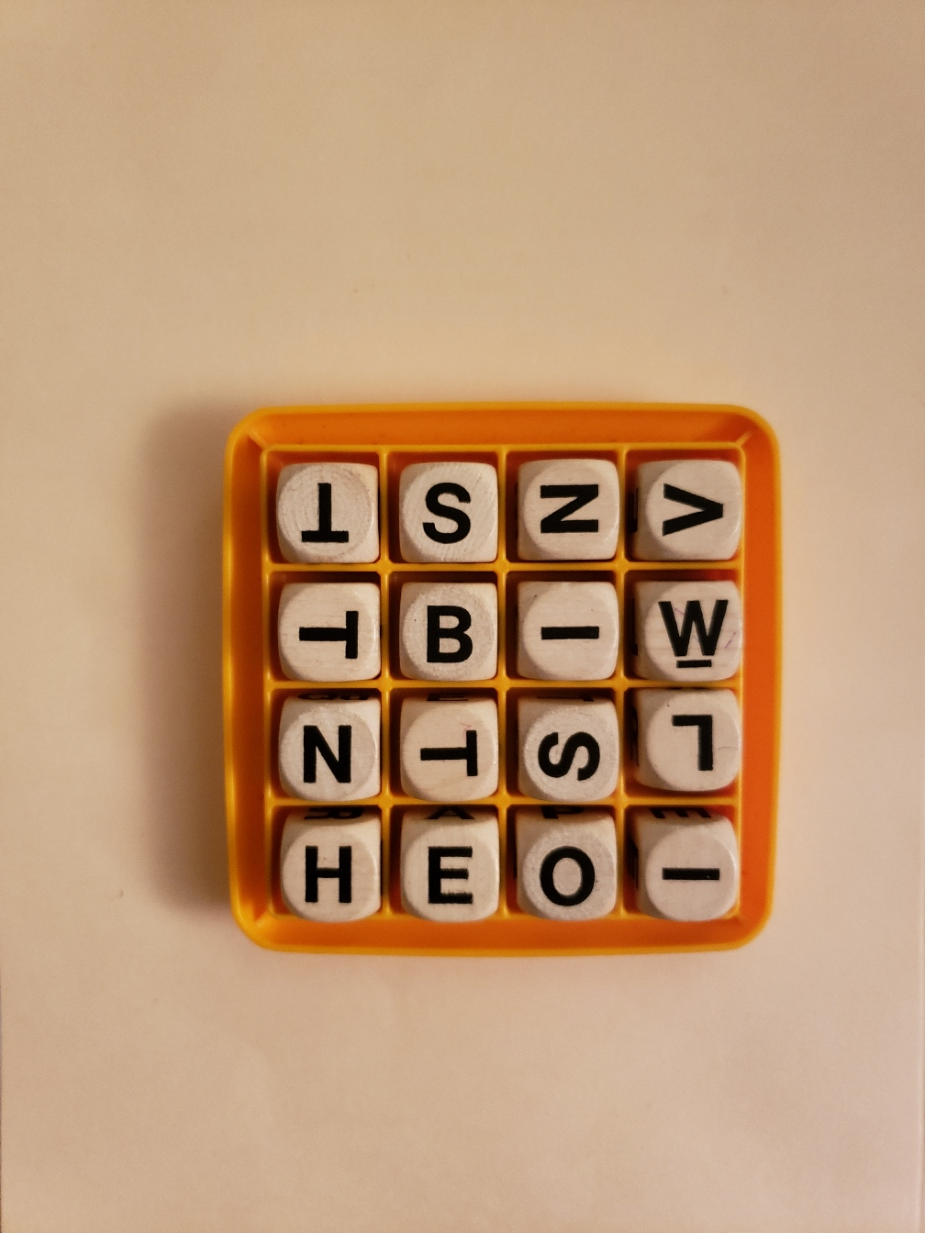

In [ ]:
# Get and store the image
img = cv2.imread('boggle-image6.jpg')

cv2_imshow(img)

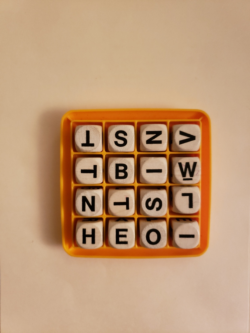

In [ ]:
# Blur the image a bit so that any noise becomes less intrusive and detrimental
blur = cv2.GaussianBlur(img, (5,5), 0)

cv2_imshow(imutils.resize(blur.copy(), width=250))

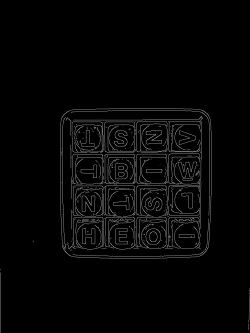

In [ ]:
# Detect all the edges in the image
edges = cv2.Canny(blur, 50, 50)

cv2_imshow(imutils.resize(edges.copy(), width=250))

In [ ]:
# Find the contours (a border of an object) and select the one with the greatest area
cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)

c = max(cnts, key=cv2.contourArea)

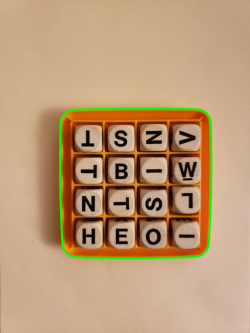

In [ ]:
# Show the largest contour drawn upon the image
imgContours = cv2.drawContours(img.copy(), [c], -1, (0, 255, 0), 5)

cv2_imshow(imutils.resize(imgContours.copy(), width=250))

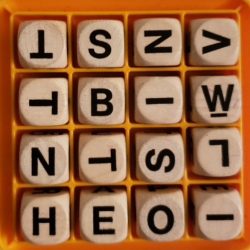

In [ ]:
# Get the bounding box coordinates of the largest contour and warp the image so that the contour is the only thing in the image
rect = np.zeros((4, 2), dtype = "float32")

x = c.reshape((c.shape[0], -1))

s = np.sum(x, axis=1)
rect[0] = x[np.argmin(s)]
rect[2] = x[np.argmax(s)]

d = np.diff(x, axis=1)
d = np.squeeze(d)
rect[1] = x[np.argmin(d)]
rect[3] = x[np.argmax(d)]

(tl, tr, br, bl) = rect
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))

dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
warped = cv2.resize(warped, (500, 500))

cv2_imshow(imutils.resize(warped.copy(), width=250))

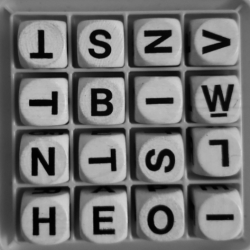

In [ ]:
# Convert the warped image to grayscale to make it easier to find the letters
warpedGray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

cv2_imshow(imutils.resize(warpedGray.copy(), width=250))

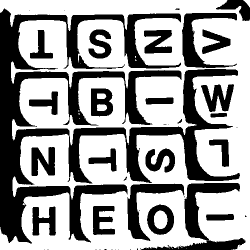

In [ ]:
# Use thresholding to convert the image to black and white only. No other shades
ret, warpedThresh = cv2.threshold(warpedGray.copy(), 0, 255, cv2.THRESH_OTSU)

cv2_imshow(imutils.resize(warpedThresh.copy(), width=250))

In [ ]:
# Find the contours in this image
warpedCnts, hier = cv2.findContours(warpedThresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
# Sort the contours based on their position (Left to right, top to bottom)

def get_contour_precedence(contour, cols):
    tolerance_factor = 50
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

warpedCnts.sort(key=lambda x:get_contour_precedence(x, warped.shape[1]))

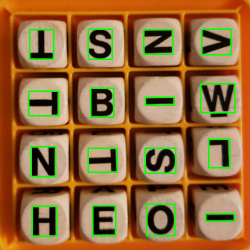

In [ ]:
# Find the position of the letters by filtering by the area and the perimeter of the contours
letters = []

for i, ctr in enumerate(warpedCnts):
  x, y, w, h = cv2.boundingRect(ctr)

  roi = warped[y:y + h, x:x + w]

  area = w * h
  lowerLimit = 40
  upperLimit = 75
  if (lowerLimit < w < upperLimit or lowerLimit < h < upperLimit) and area > 500:
    letters.append(roi)
    rect = cv2.rectangle(warped, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(imutils.resize(warped.copy(), width=250))

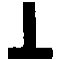

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.


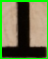

predicted letter:  T


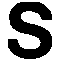

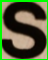

predicted letter:  S


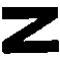

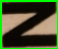

predicted letter:  N


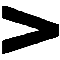

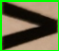

predicted letter:  V


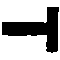

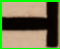

predicted letter:  T


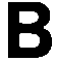

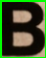

predicted letter:  B


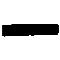

predicted letter:  I


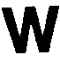

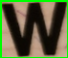

predicted letter:  W


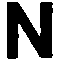

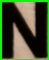

predicted letter:  N


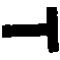

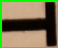

predicted letter:  T


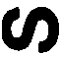

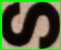

predicted letter:  S


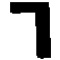

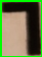

predicted letter:  L


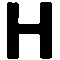

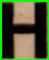

predicted letter:  H


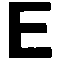

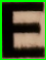

predicted letter:  E


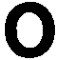

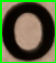

predicted letter:  O


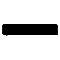

predicted letter:  I
predicted letters:  ['T', 'S', 'N', 'V', 'T', 'B', 'I', 'W', 'N', 'T', 'S', 'L', 'H', 'E', 'O', 'I']


In [ ]:
# Use the extracted letters and predict what they are
predLetters = []

# Loop through all the letters
for letter in letters:
  # Convert the letter to grayscale
  letterGray = cv2.cvtColor(letter, cv2.COLOR_BGR2GRAY)

  # Convert the letter to black and white only by thresholding the image
  ret, letterThresh = cv2.threshold(letterGray.copy(), 0, 255, cv2.THRESH_OTSU)

  # Resize the image to 60x60 since that is the size of the labelled letters
  # I do so by adding white pixels to the shorter side
  desired_size = 60
  old_size = letterThresh.shape[:2] # old_size is in (height, width) format
  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  letterThresh = cv2.resize(letterThresh, (new_size[1], new_size[0]))

  delta_w = desired_size - new_size[1]
  delta_h = desired_size - new_size[0]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  color = [255, 255, 255]
  letterThresh = cv2.copyMakeBorder(letterThresh, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color) # Adding the border here
  rotImage = letterThresh

  cv2_imshow(letterThresh)

  mseVals = []

  # Rotate each letter four times
  for x in range(4):
    rotImage = np.rot90(rotImage)

    # Compare each rotated letter with a labelled image
    for l in range(26):
      compareLetter = cv2.imread(chr(65+l) + ".png")
      comapareLetterGray = cv2.cvtColor(compareLetter, cv2.COLOR_BGR2GRAY)
      comapareLetterGray = cv2.GaussianBlur(comapareLetterGray, (5, 5), 0)

      ret, compareLetterThresh = cv2.threshold(comapareLetterGray, 127, 255, cv2.THRESH_OTSU)

      # Calculate the MSE of the two images to find their similarity
      m = mse(rotImage, compareLetterThresh)

      mseVals.append(m)

  minMSE = np.amin(mseVals)

  predIndex = np.argmin(mseVals)

  while predIndex >= 26:
    predIndex -= 26

  predLetter = chr(65+predIndex)

  predLetters.append(predLetter)

  cv2_imshow(letter)
  print("predicted letter: ", predLetter)
print("predicted letters: ", predLetters)